In [1]:
import tensorflow as tf

import numpy as np
import IPython.display as display

import os
import pandas as pd

import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_DIR = "/content/drive/My Drive/ppk"
IMG_DIR = os.path.join(BASE_DIR, "images/raw")
CLASSED_IMG_DIR = os.path.join(BASE_DIR, "images/classed")

In [4]:
%cd "/content/drive/My Drive/ppk/images"

/content/drive/My Drive/ppk/images


In [5]:
%ls

classed/  raw/  train_images.tfrecords


In [6]:
train_labels_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
test_labels_df = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))

In [7]:
train_labels_df.tail(), test_labels_df.tail()

(        image_id  healthy  multiple_diseases  rust  scab
 1816  Train_1816        0                  0     0     1
 1817  Train_1817        1                  0     0     0
 1818  Train_1818        1                  0     0     0
 1819  Train_1819        0                  0     1     0
 1820  Train_1820        0                  0     0     1,        image_id
 1816  Test_1816
 1817  Test_1817
 1818  Test_1818
 1819  Test_1819
 1820  Test_1820)

In [ ]:
# train_filenames = []
# test_filenames = []

# for file in os.listdir(IMG_DIR):
#     if file.endswith(".jpg"):
#       if file.startswith("Train"):
#         train_filenames.append(file)
#       if file.startswith("Test"):
#         test_filenames.append(file)

In [ ]:
# train_filenames[-5:], len(train_filenames), test_filenames[-5:], len(test_filenames)

(['Train_1007.jpg',
  'Train_12.jpg',
  'Train_1019.jpg',
  'Train_1163.jpg',
  'Train_1259.jpg'],
 1821,
 ['Test_1003.jpg',
  'Test_195.jpg',
  'Test_1170.jpg',
  'Test_239.jpg',
  'Test_1365.jpg'],
 1821)

## TFRecords below

In [8]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

build labels dict by opening file storing in variable use variable as dict key and label as value through for loop

In [9]:
train_imag_labels = {}
for rec in train_labels_df.to_records(index=False):
  if rec[1] == 1:
    label = 0
  if rec[2] == 1:
    label = 1
  if rec[3] == 1:
    label = 2
  if rec[4] == 1:
    label = 3
  train_imag_labels[rec[0] + ".jpg"] = label

In [16]:
test_imag_labels = {}
for rec in test_labels_df.to_records(index=False):
  label = -1
  test_imag_labels[rec[0] + ".jpg"] = label

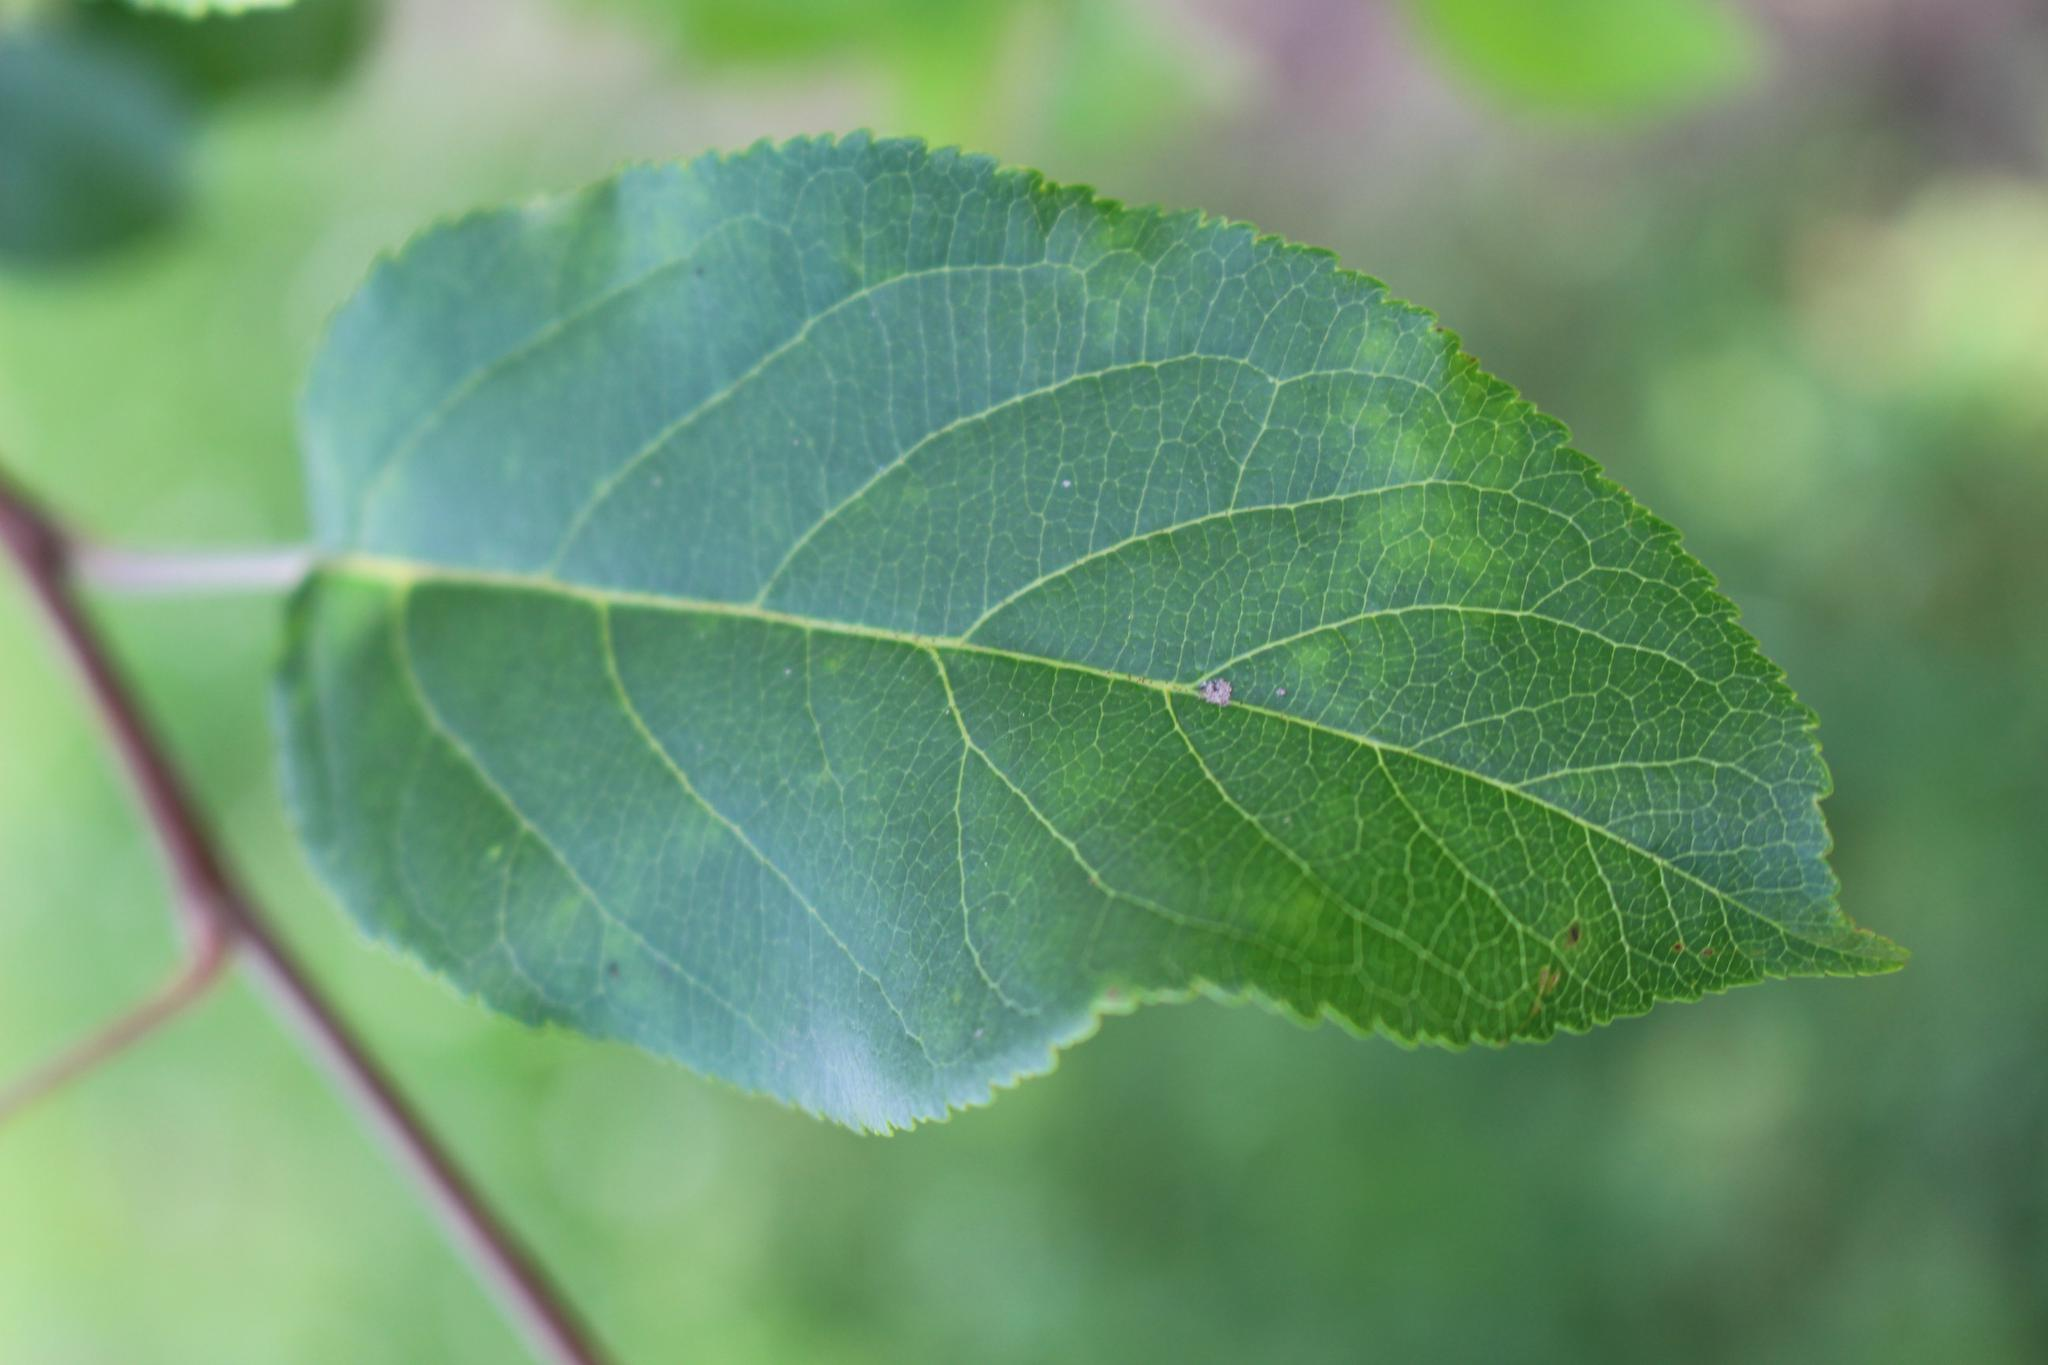

In [11]:
display.display(display.Image(filename=os.path.join(IMG_DIR, 'Train_737.jpg')))

In [17]:
# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 1365
      }


In [13]:
record_file = 'train_images.tfrecords'

# with tf.io.TFRecordWriter(record_file) as writer:
#   for filename, label in train_imag_labels.items():
#     image_string = open(os.path.join(IMG_DIR, filename), 'rb').read()
#     tf_example = image_example(image_string, label)
#     writer.write(tf_example.SerializeToString())



In [14]:
!du -sh {record_file}

384M	train_images.tfrecords


In [18]:
record_file = 'test_images.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in test_imag_labels.items():
    image_string = open(os.path.join(IMG_DIR, filename), 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())



In [19]:
!du -sh {record_file}

403M	test_images.tfrecords


In [20]:
raw_train_image_dataset = tf.data.TFRecordDataset('train_images.tfrecords')

In [21]:
raw_test_image_dataset = tf.data.TFRecordDataset('test_images.tfrecords')

In [22]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)


In [23]:

parsed_train_image_dataset = raw_train_image_dataset.map(_parse_image_function)
parsed_train_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

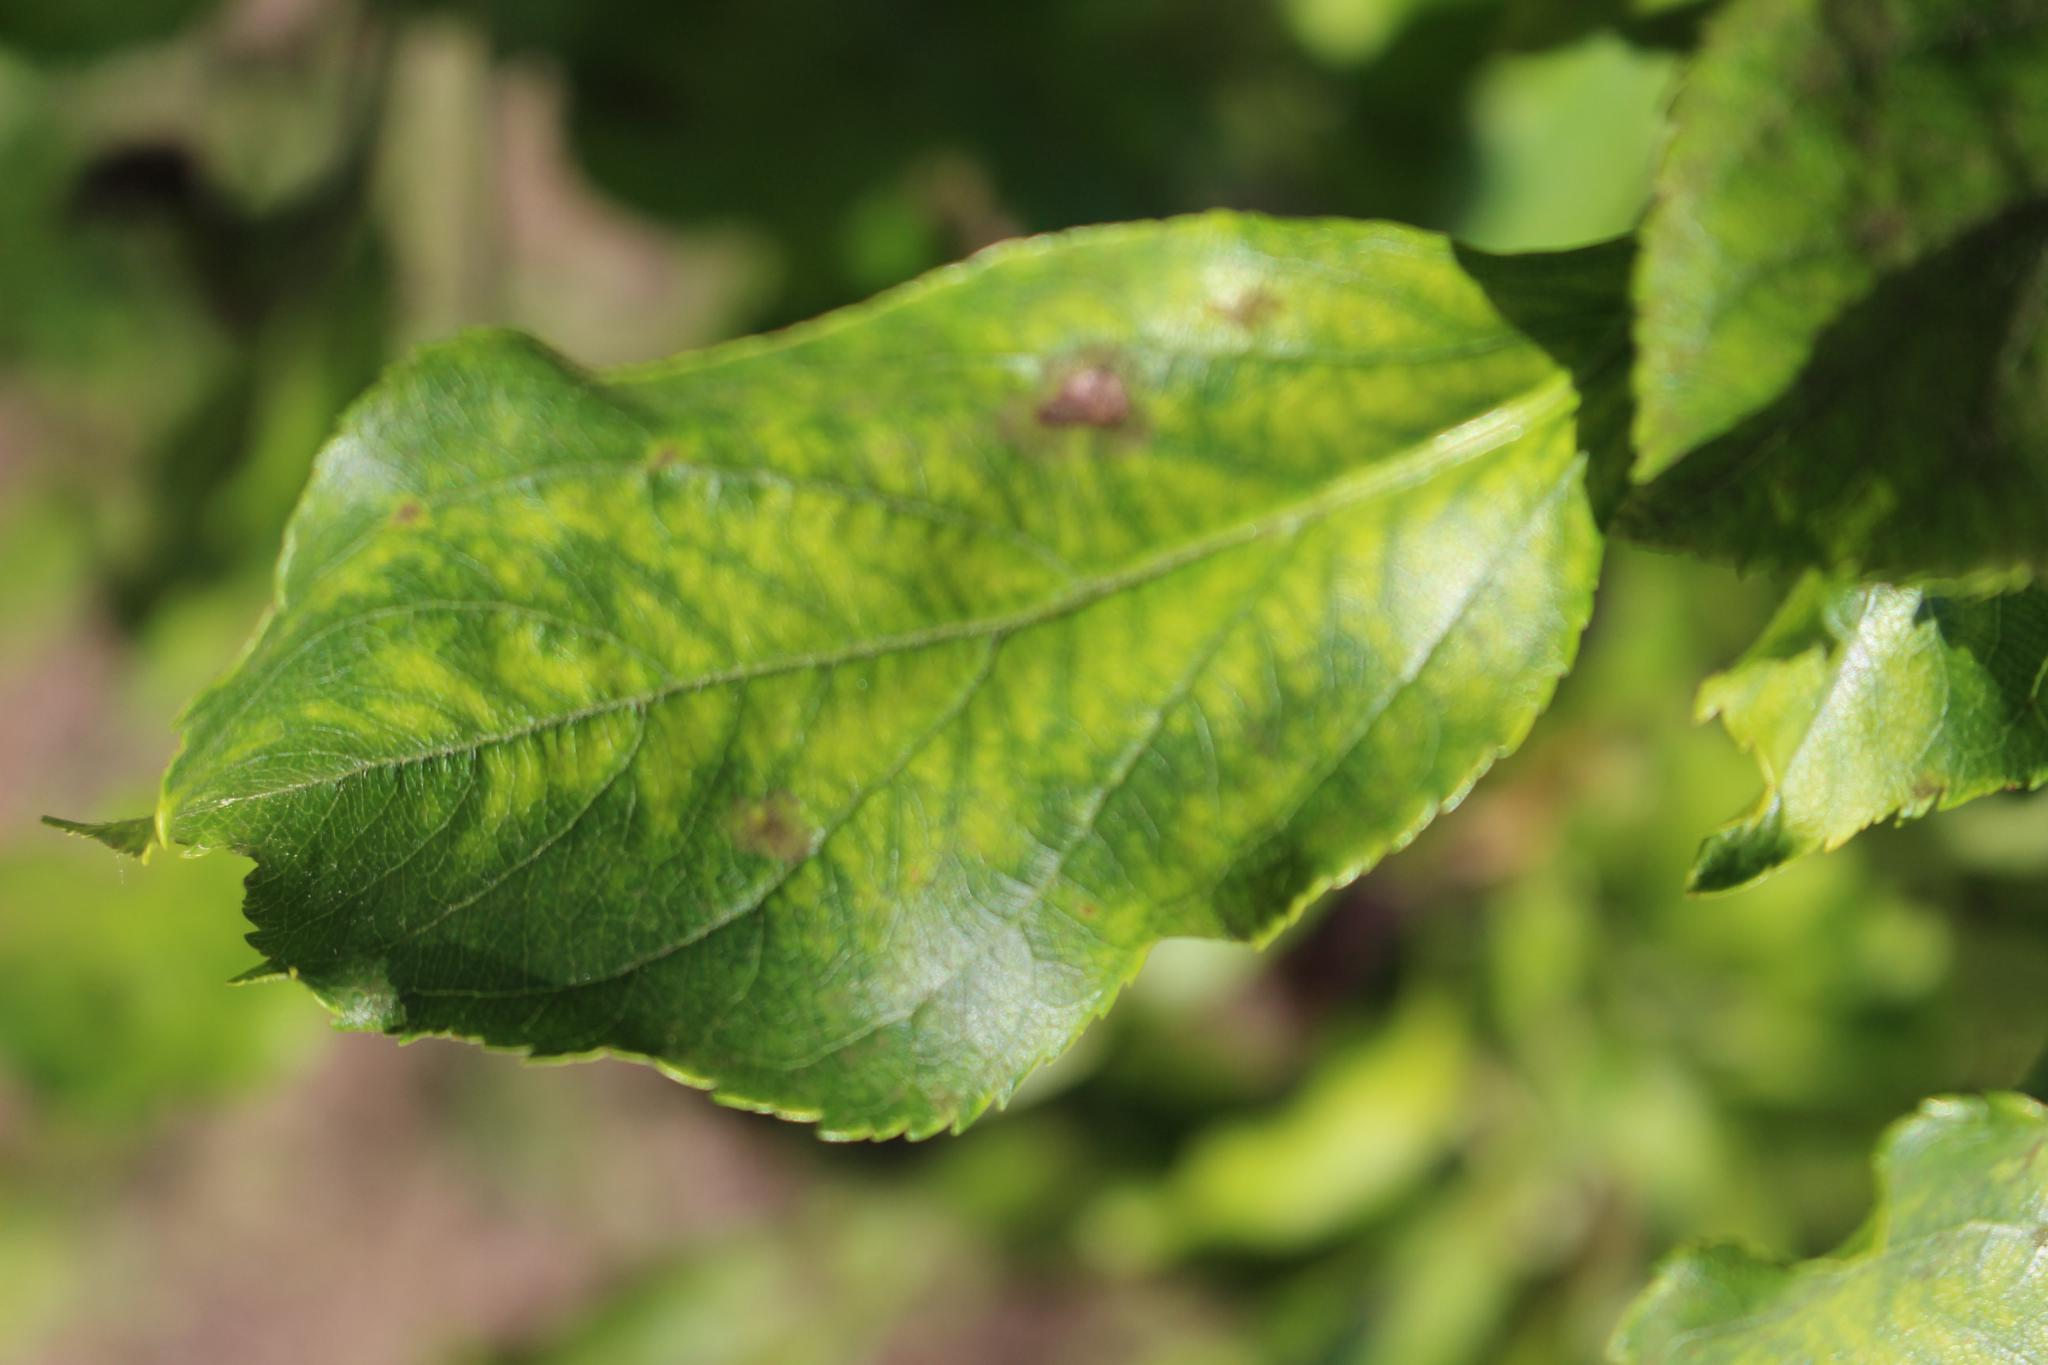

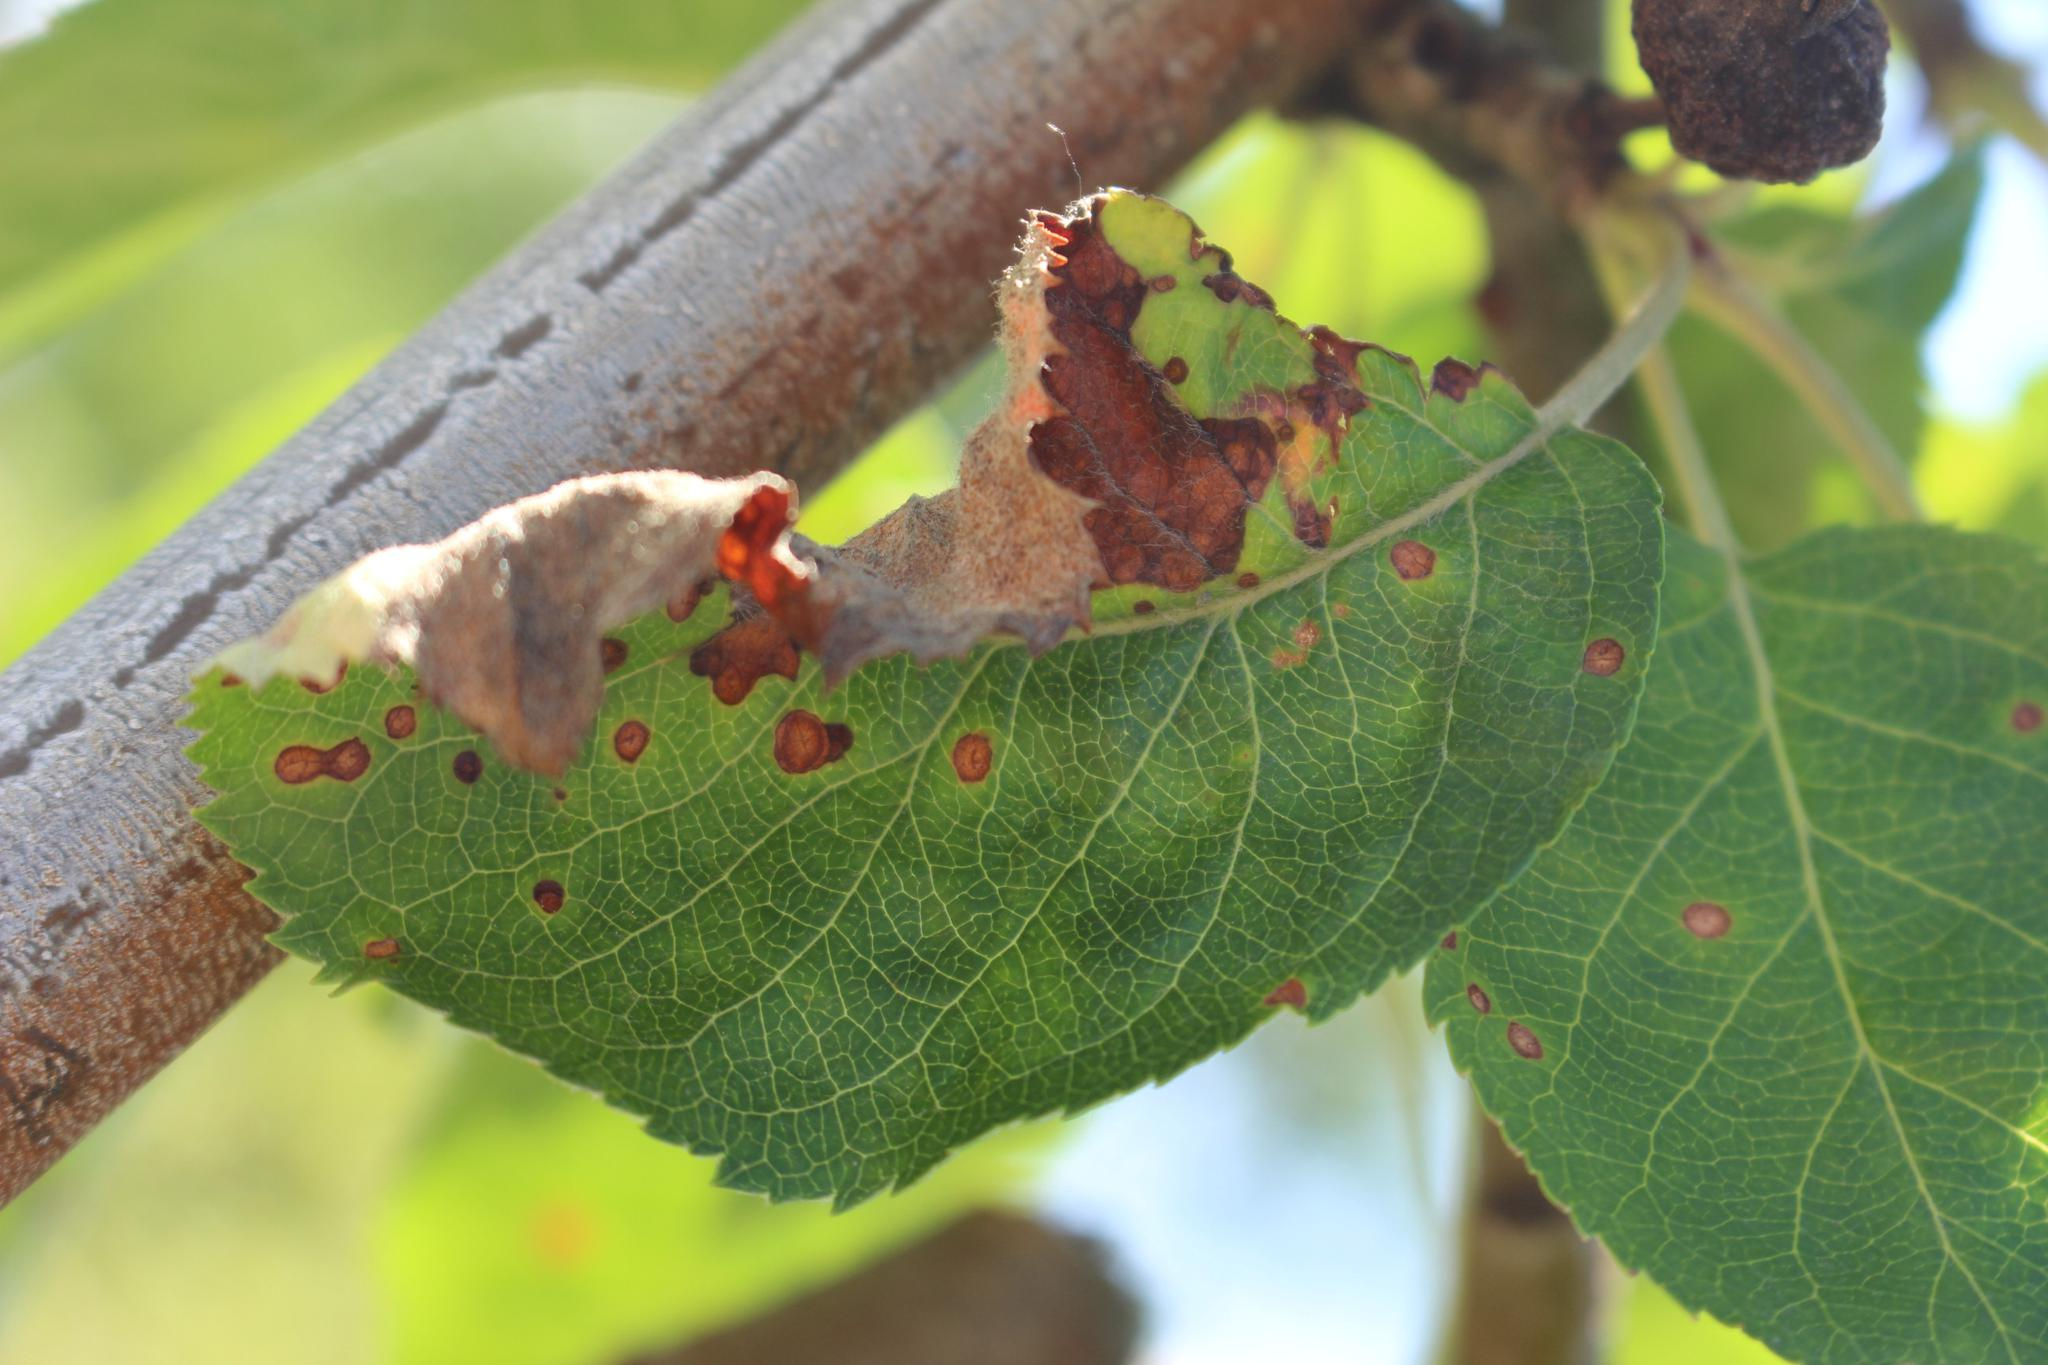

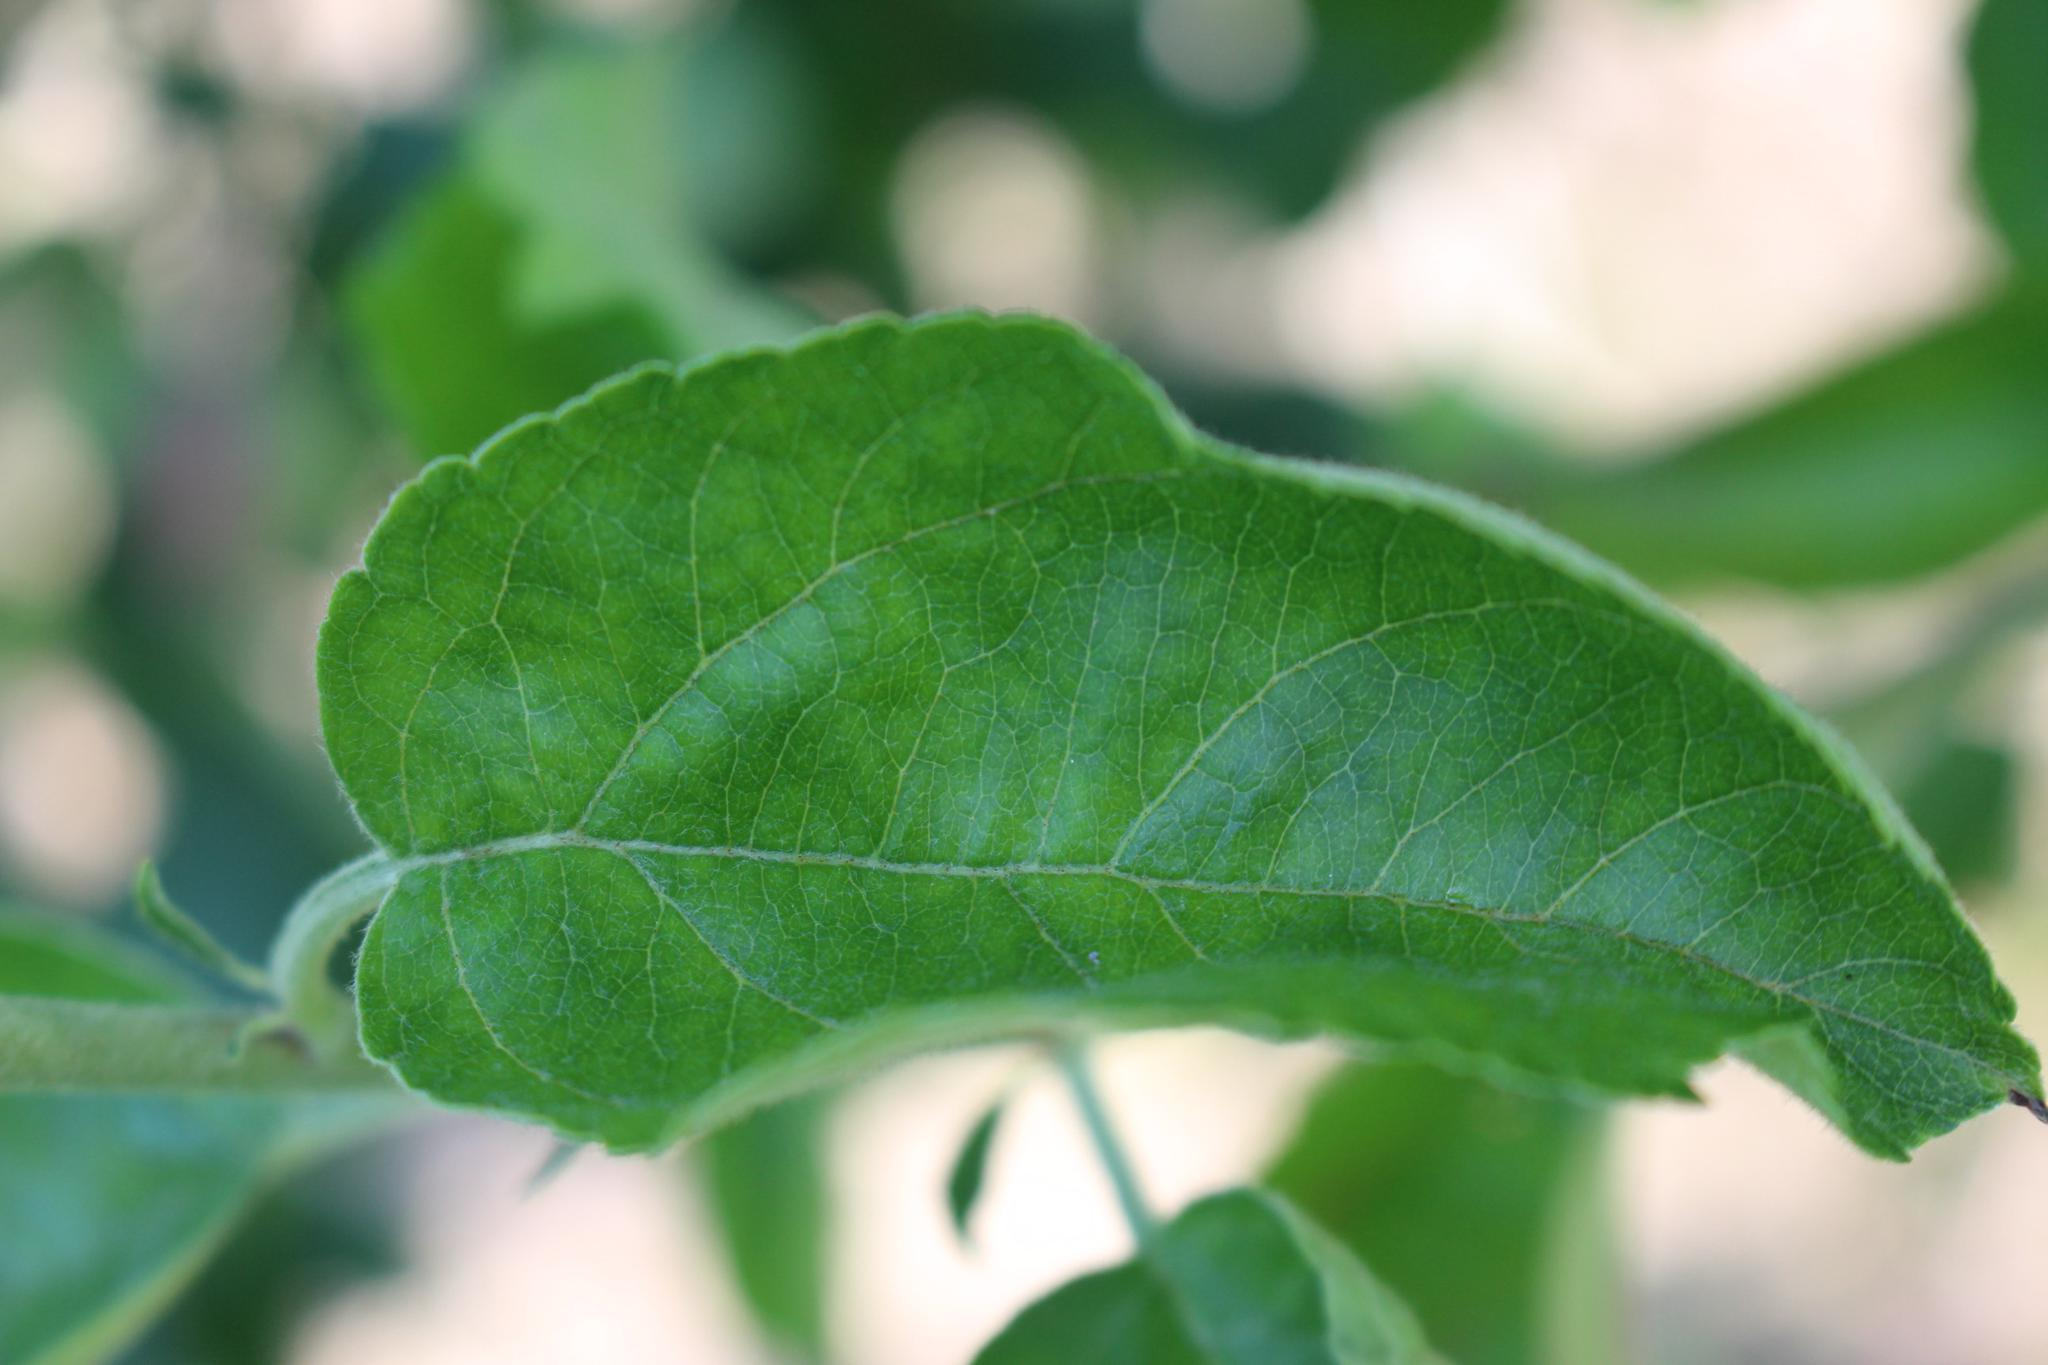

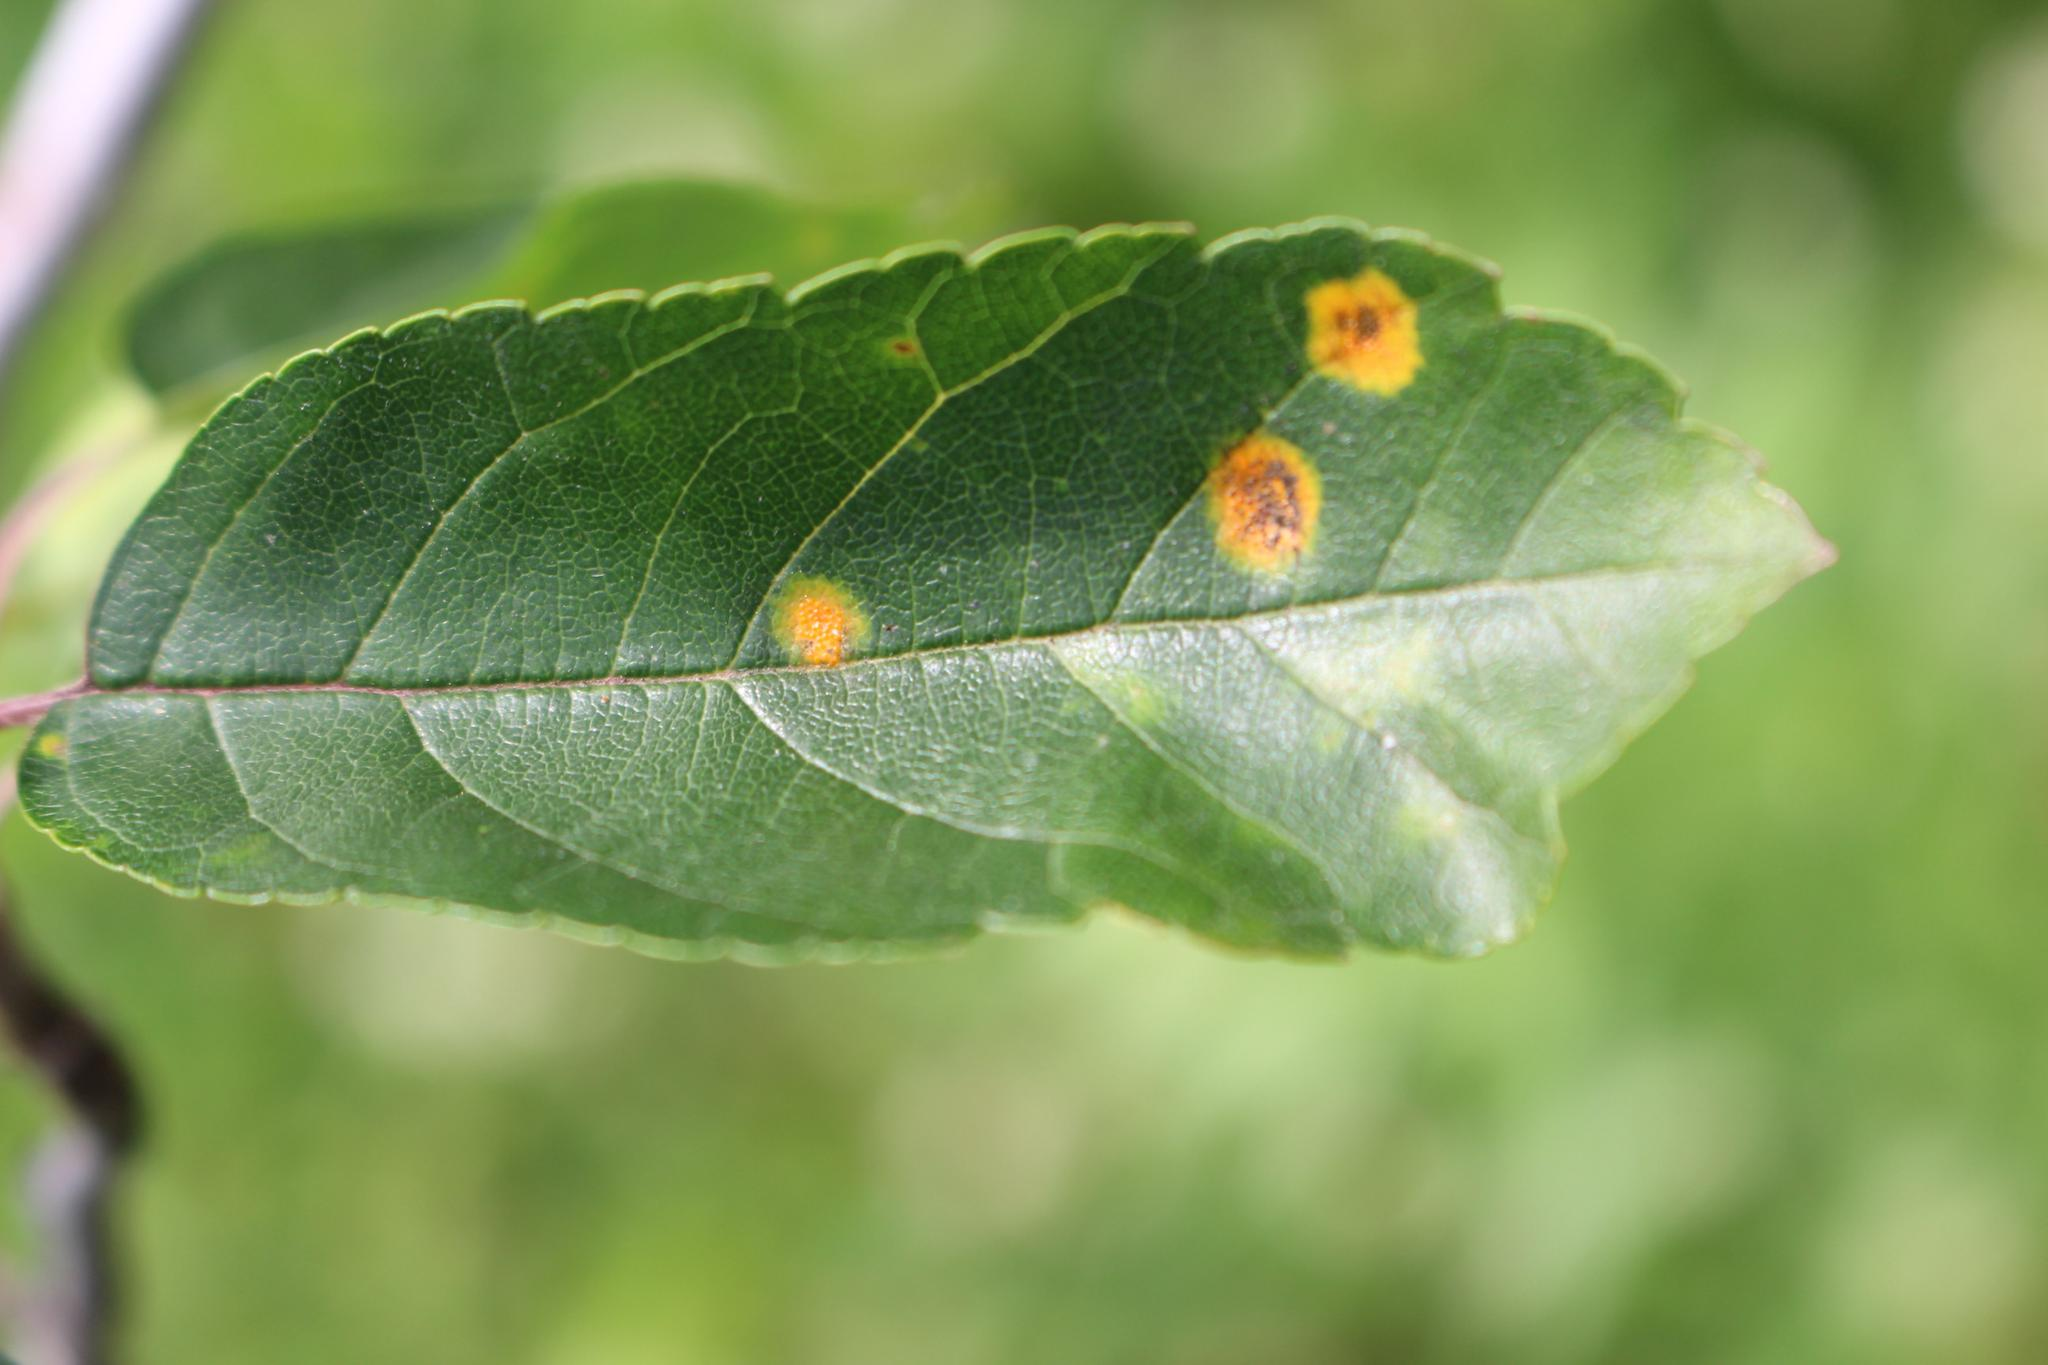

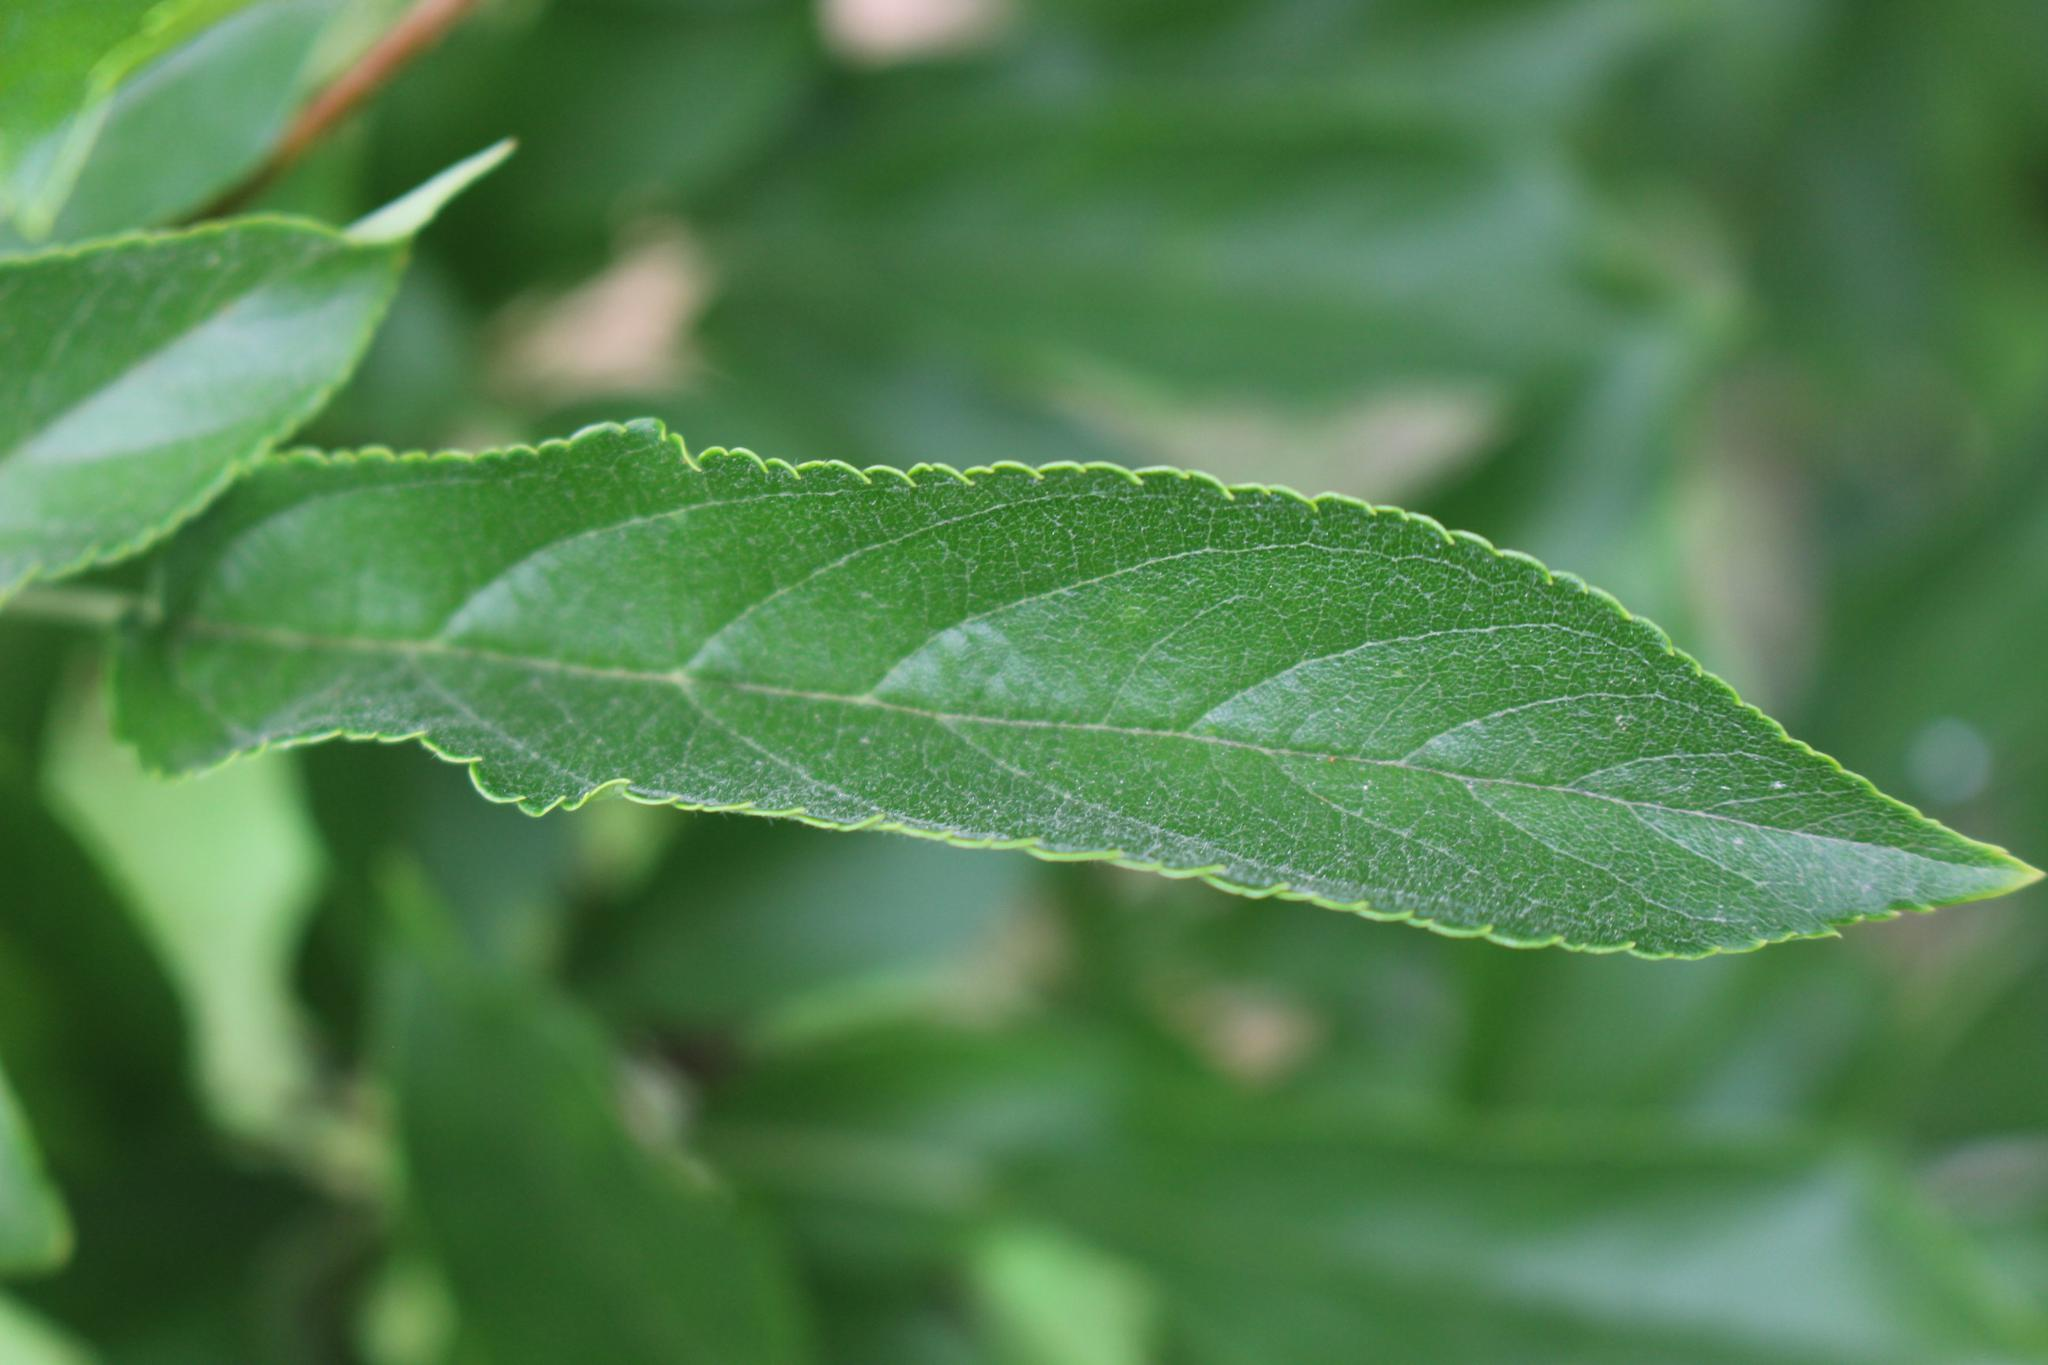

In [25]:
for image_features in parsed_train_image_dataset.take(5):
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))

In [26]:

parsed_test_image_dataset = raw_test_image_dataset.map(_parse_image_function)
parsed_test_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

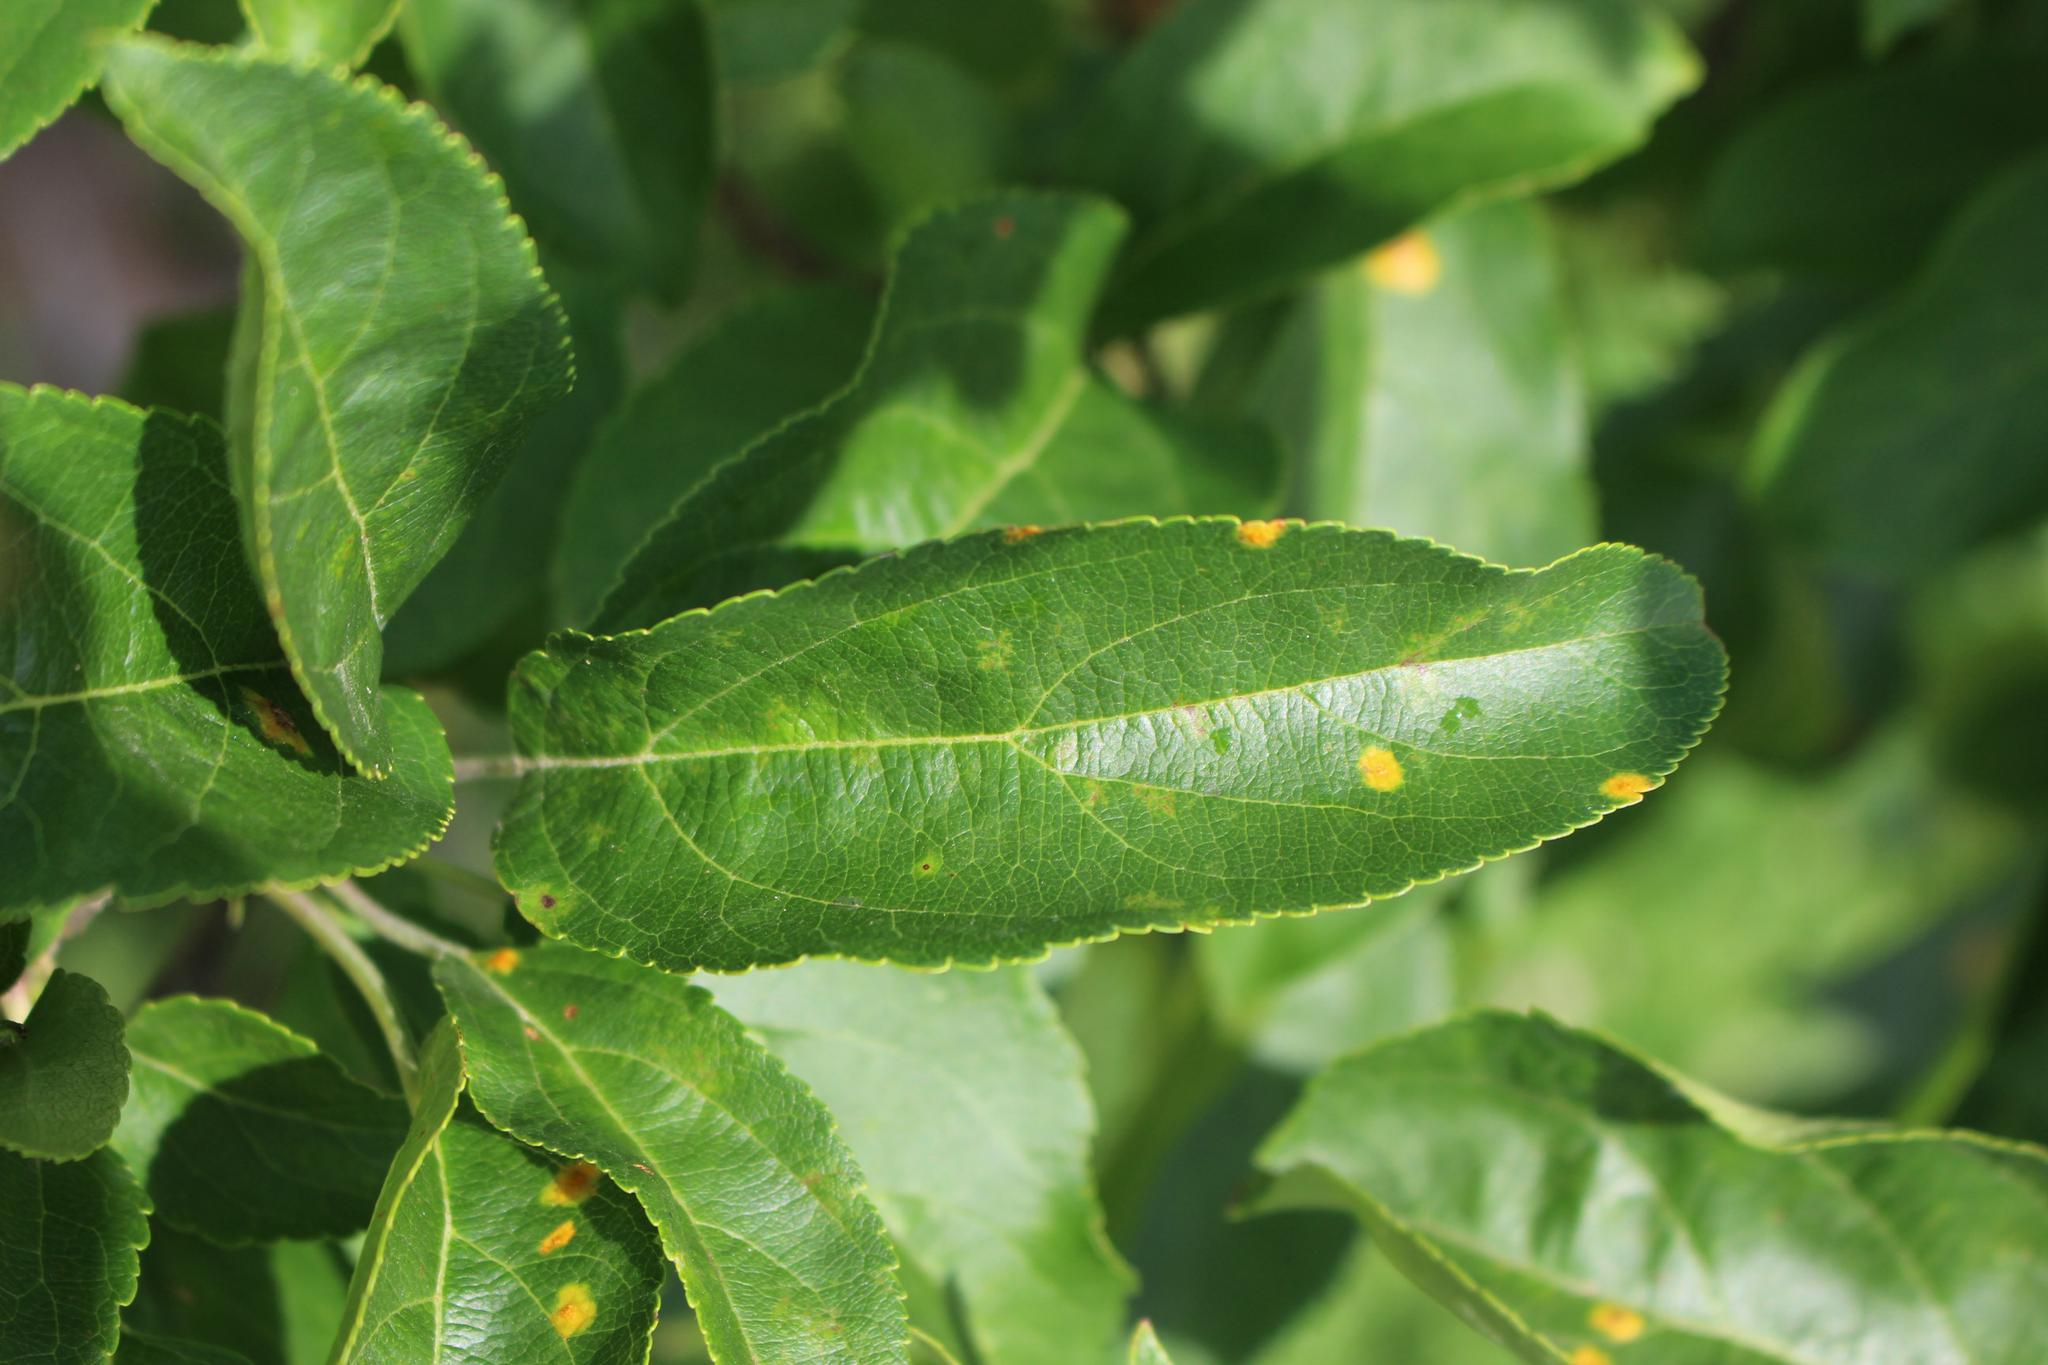

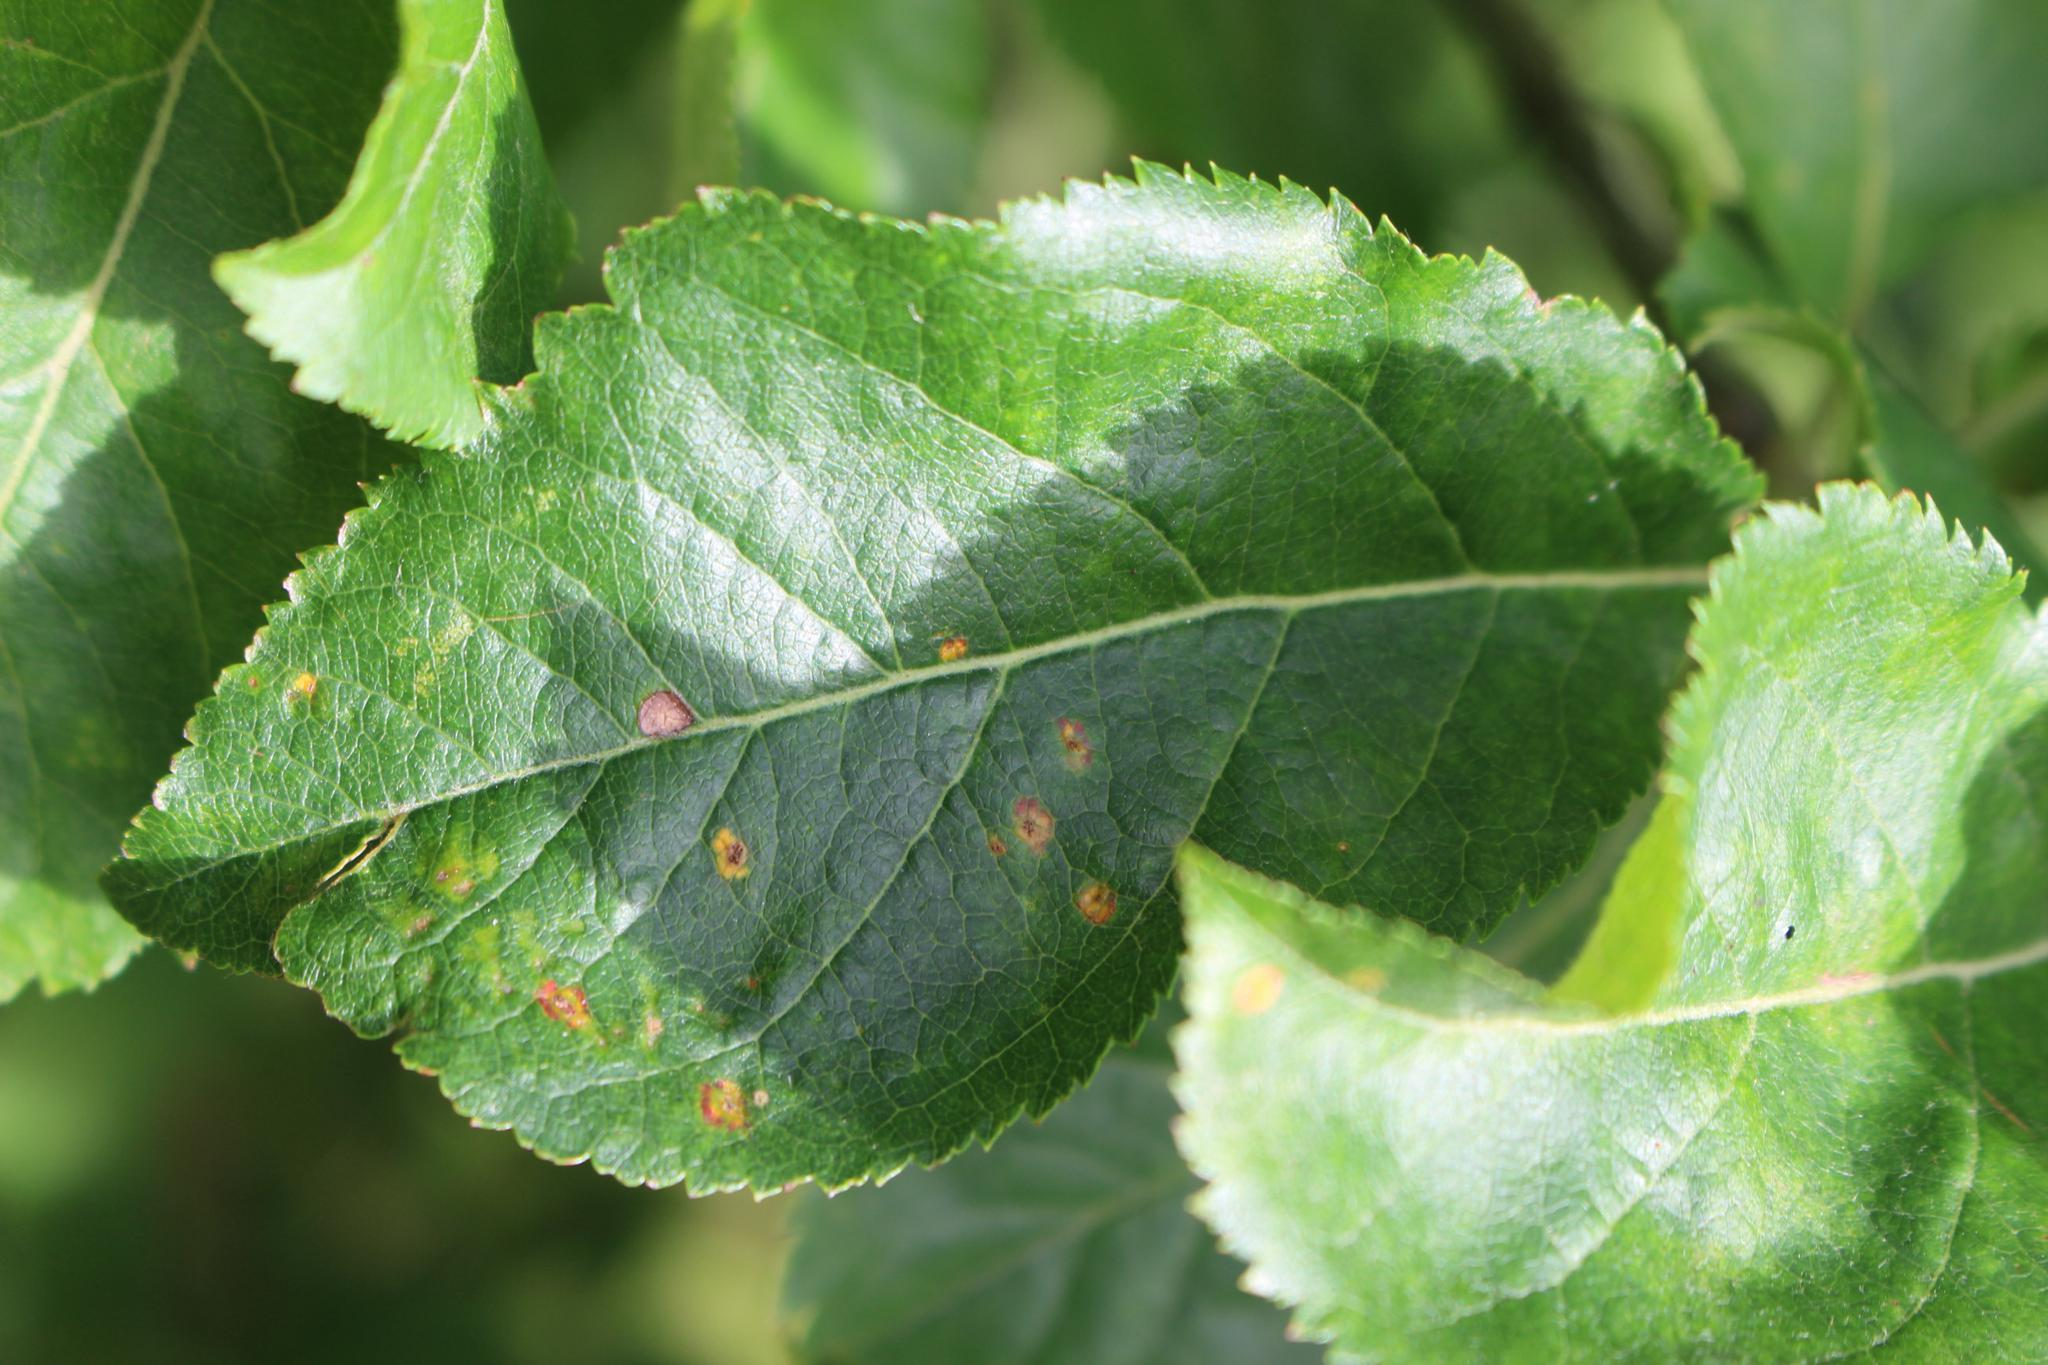

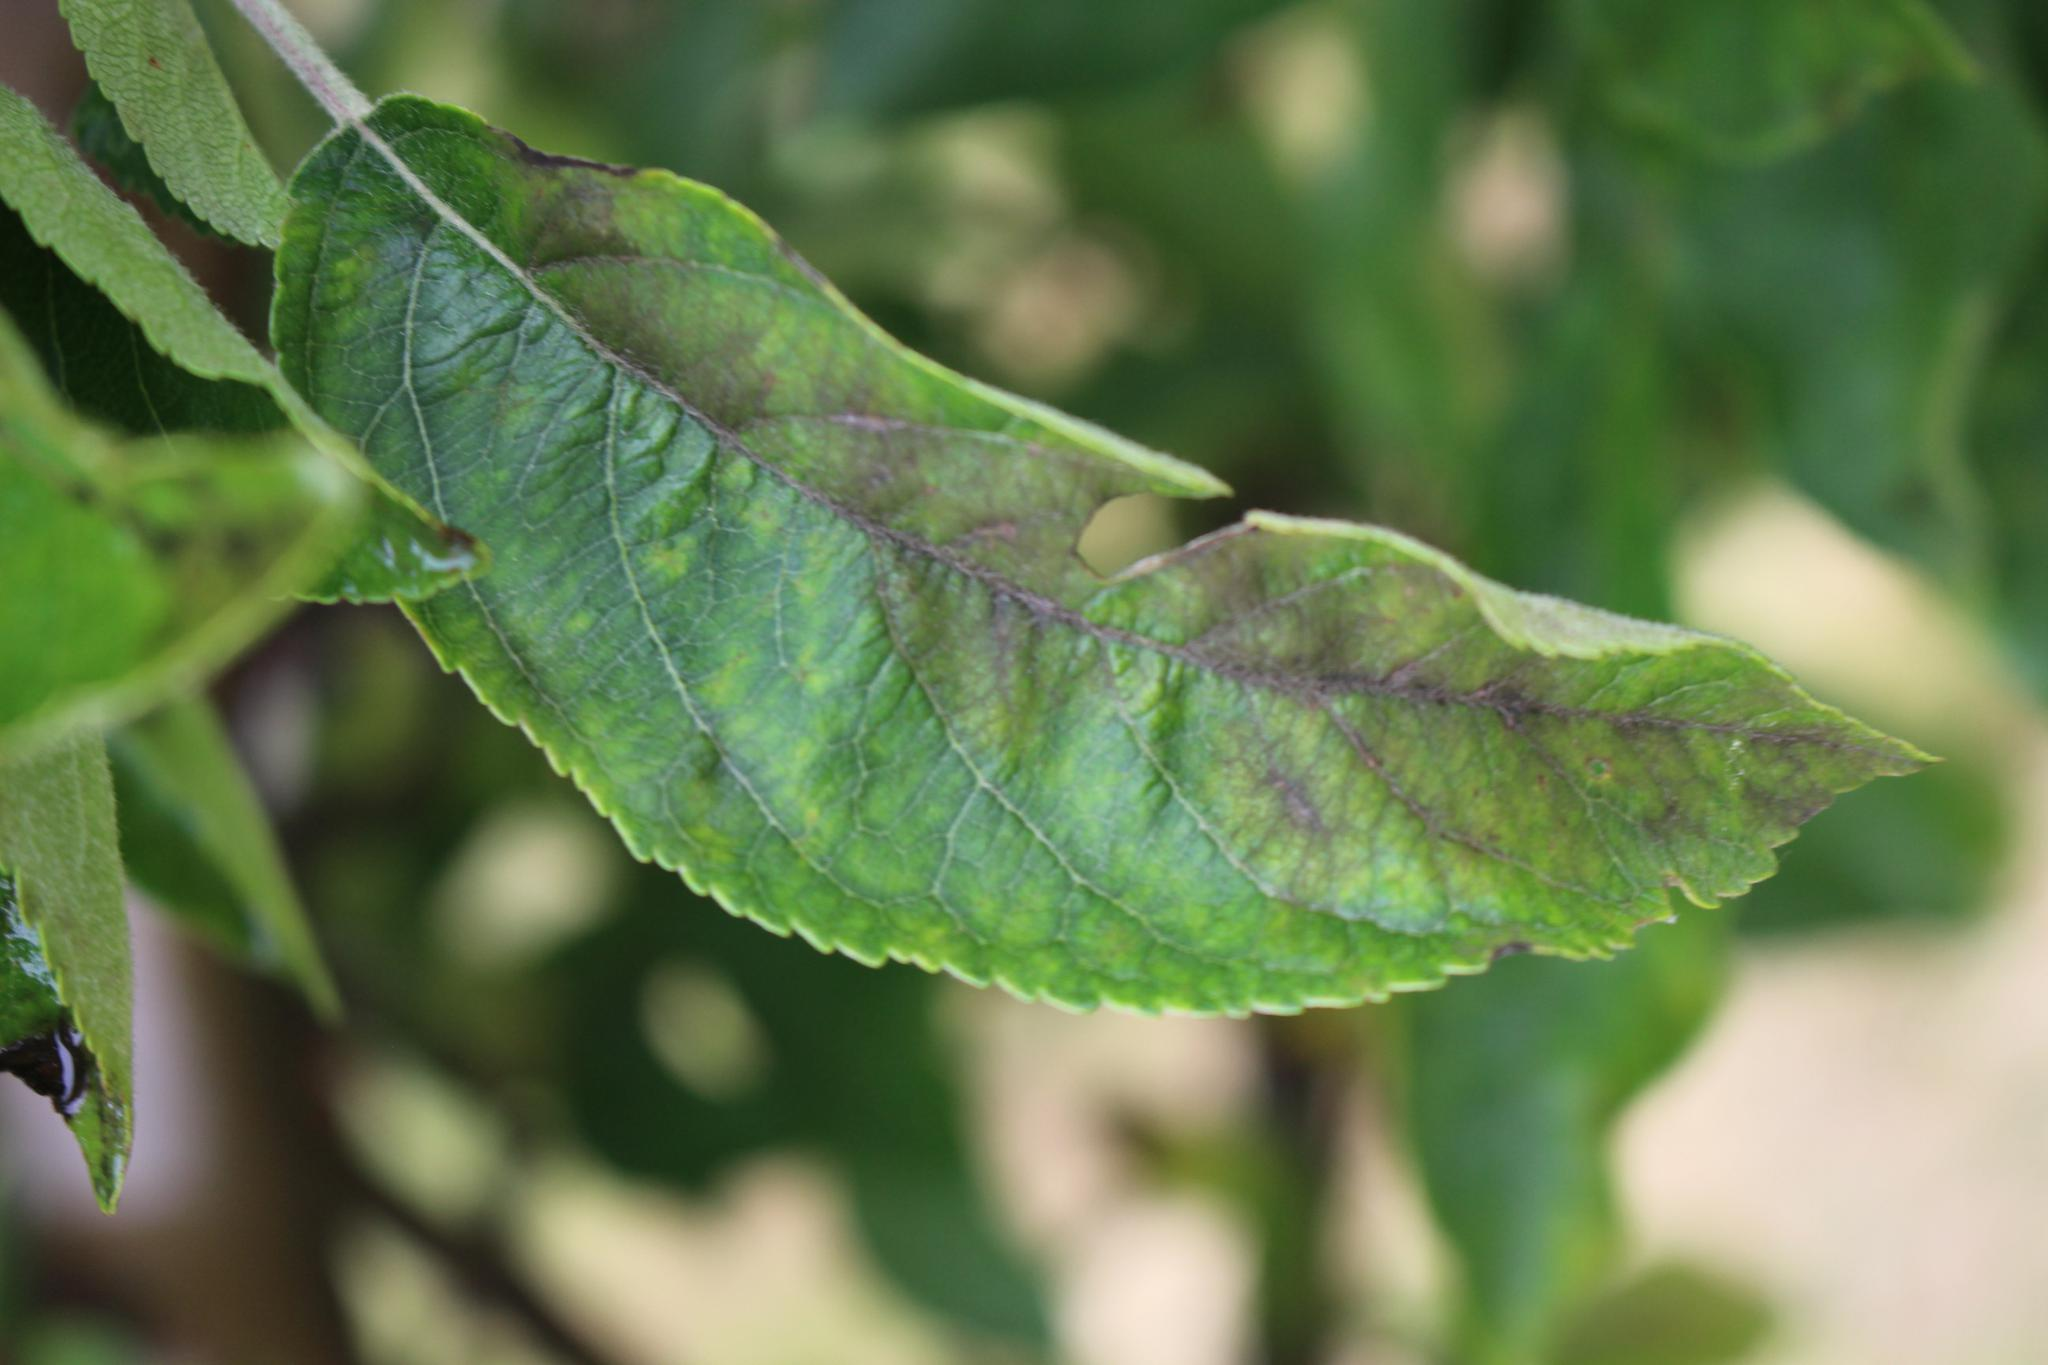

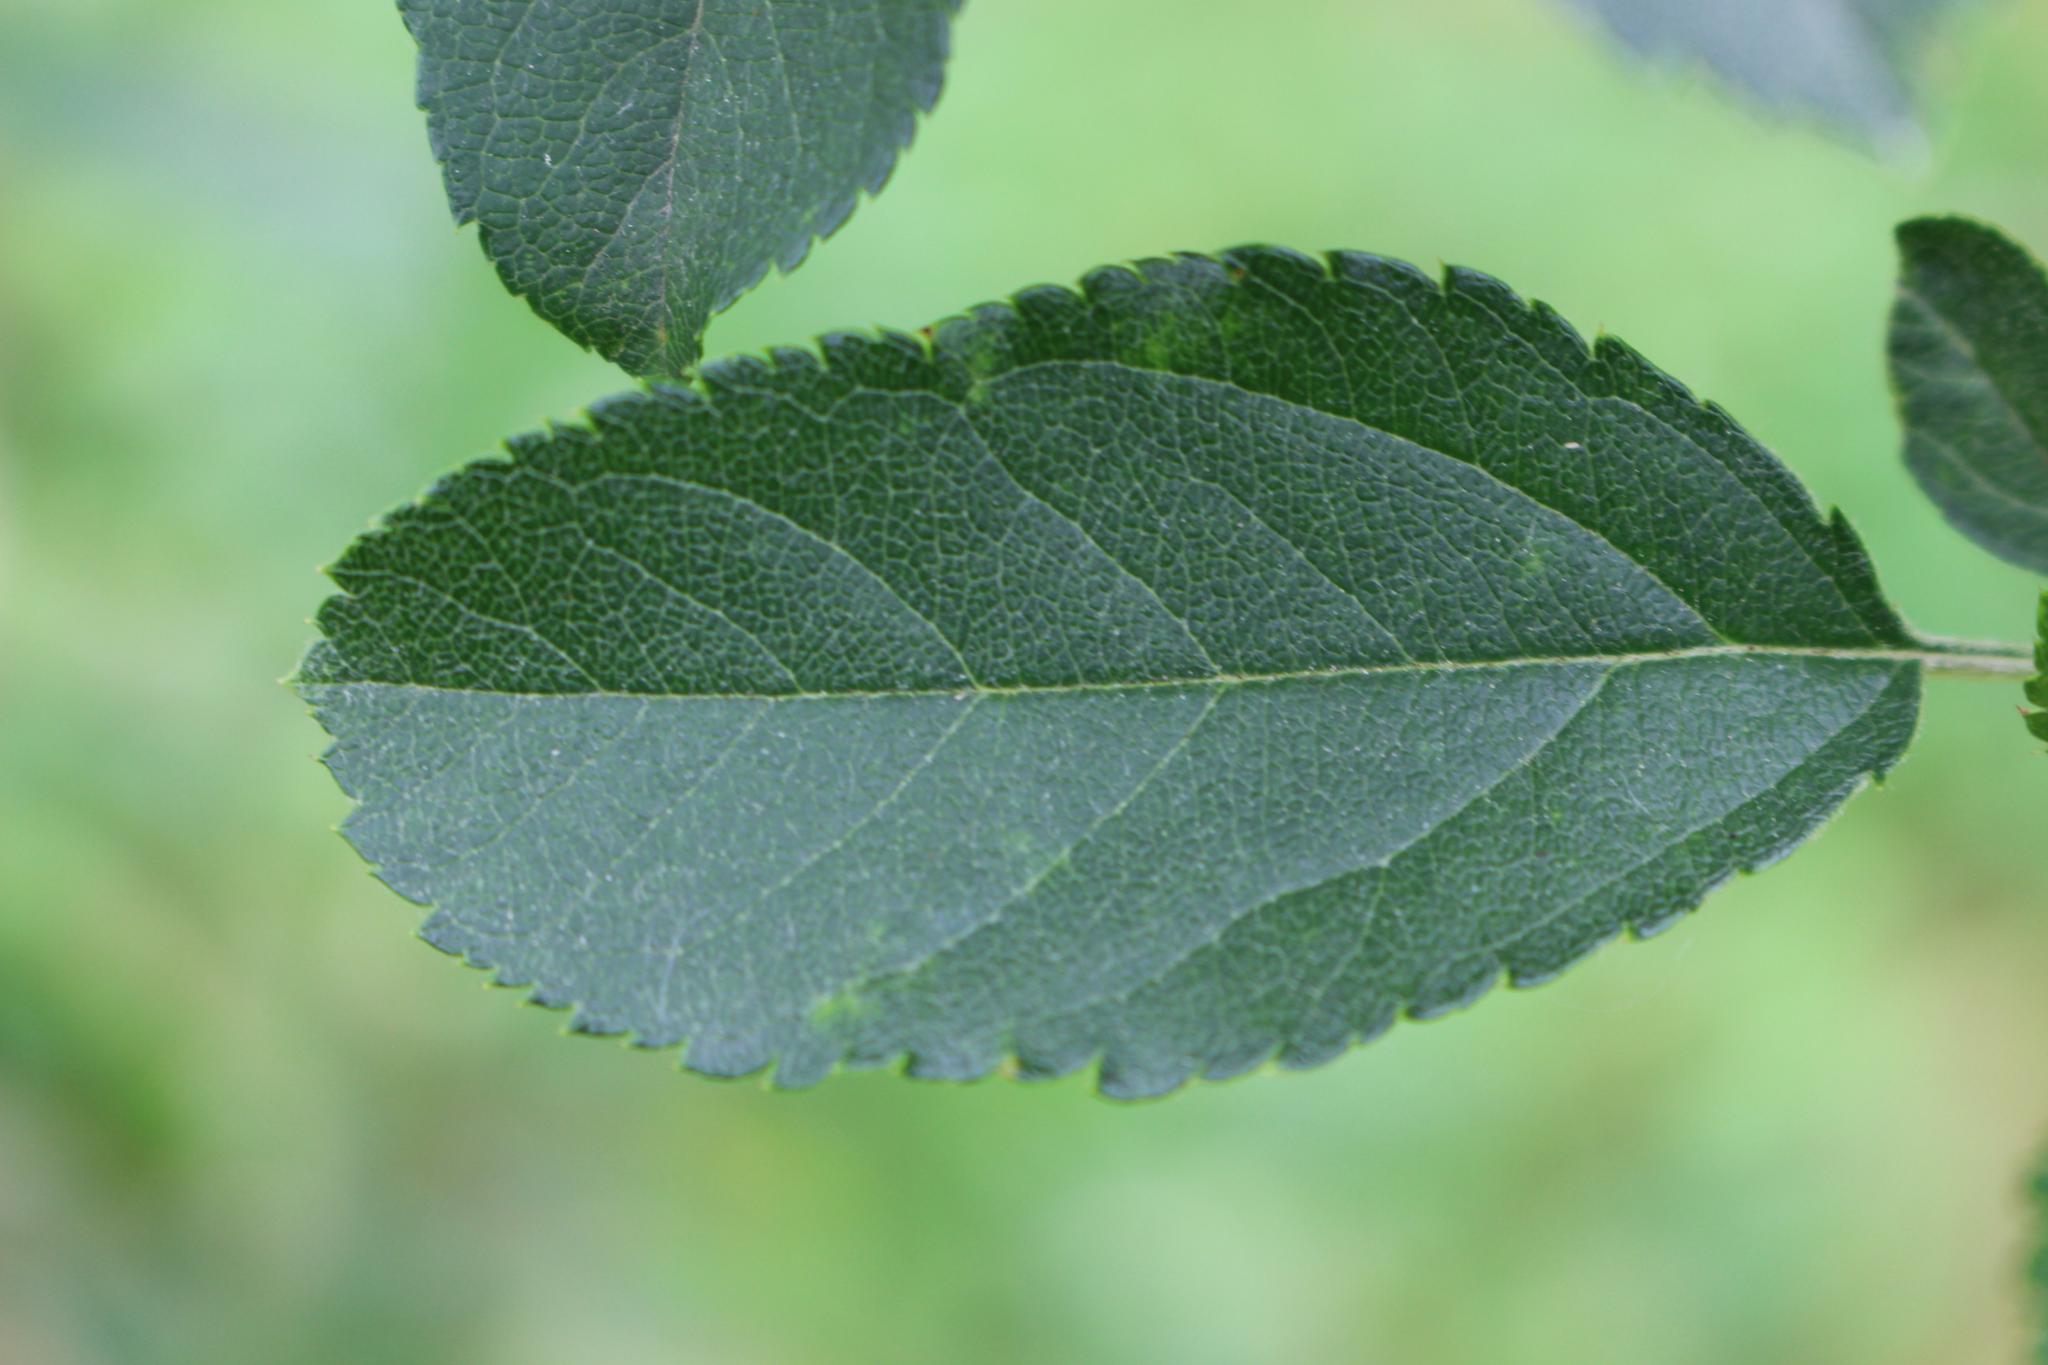

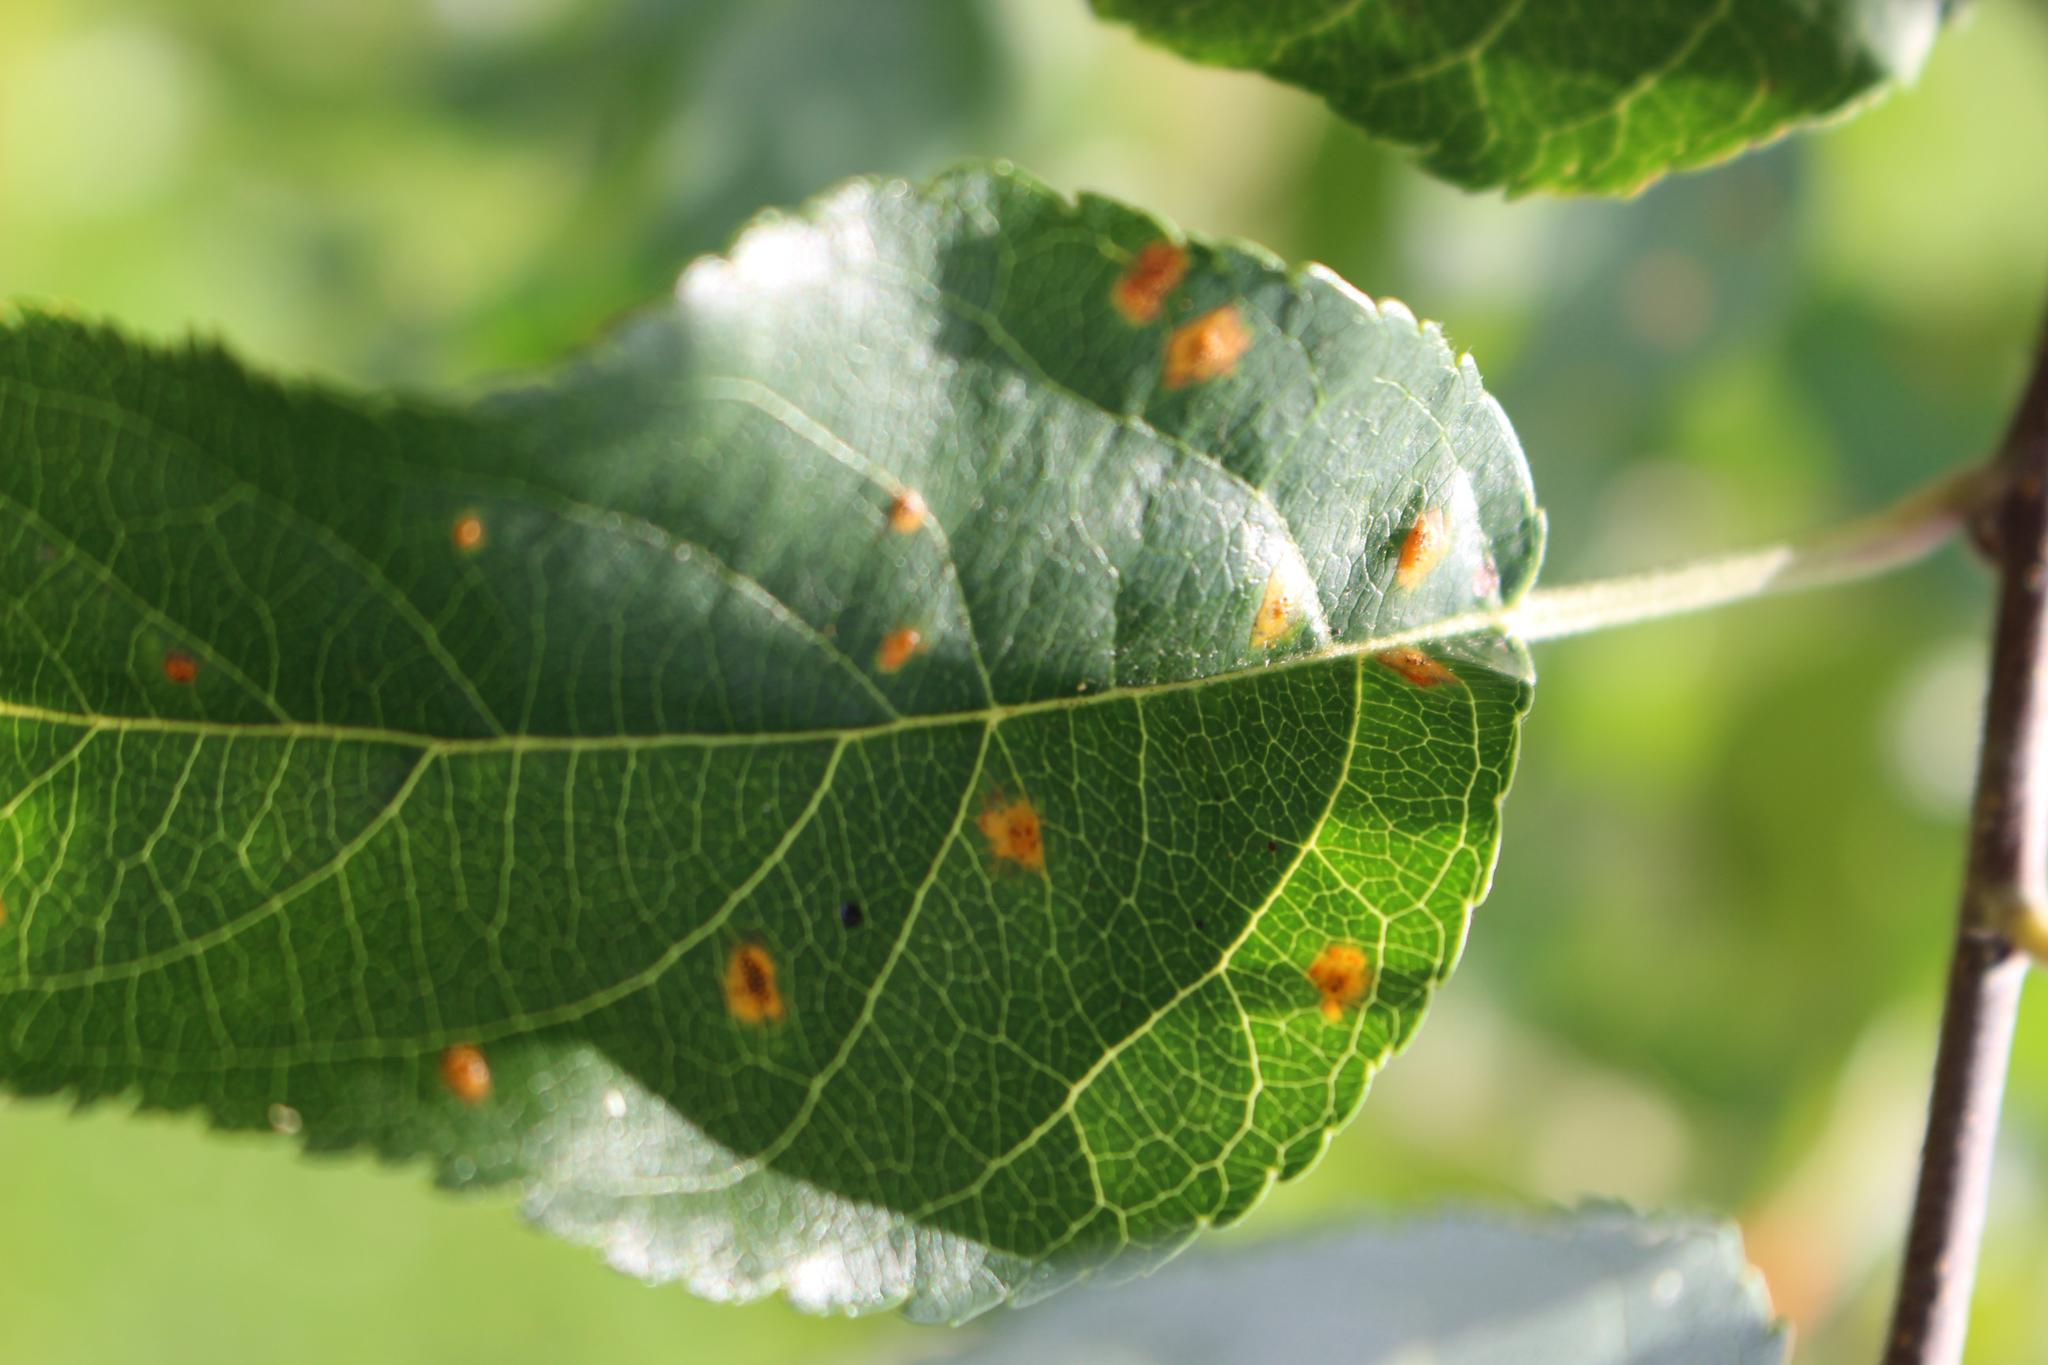

In [27]:
for image_features in parsed_test_image_dataset.take(5):
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))